In [1]:
import numpy as np
import numpy.lib.stride_tricks as slide
import imageio as iio
import multiprocessing
import re
import io
import math
import glob
import tools

class Sample:
    def __init__(self, path):
        self.path = path
        classMatch = re.search('[\\\/]([a-zA-Z]+)(\d+)\.(\w+)', path)
        self.klass = classMatch.group(1).lower()
        self.number = int(classMatch.group(2))
        self.extension = classMatch.group(3)
        self.klassId = tools.CLASSES.index(self.klass)
        
    def __str__(self):
        return f'{self.path} {self.klass} {self.number}'
    def __repr__(self):
        return f'{self.path} {self.klass} {self.number}'
        
    def readImage(self):
        return iio.imread(self.path)
    
    def writeImage(self, buffer, base, extension):
        if not extension:
            extension = self.extension
        iio.imgwrite(f'{base}/{self.klass}{str(self.number).zfill(3)}.{extension}', buffer)
        


def buildSampleList(pathGlob):
    samples = []
    for i, filePath in enumerate(glob.glob(pathGlob)):
        samples.append(Sample(filePath))
    return samples;
        


In [486]:

def compareOverlay(base, oppose):
    return np.count(base - oppose) / np.count(base)

def extractSegmentFeatures(patch, steps = 10):
    step = 2.0*math.pi / steps
    accum = 0
    origSize = np.count_nonzero(patch)
    side = np.max(patch.shape)
    padding = ((side - patch.shape[0] + side) // 2, (side - patch.shape[1] + side) // 2)
    padded = np.pad(patch, padding)
    com = scipy.ndimage.center_of_mass(padded)
    line = np.zeros(padded.shape)
    line[round(com[0])] = 1
    perim = np.count_nonzero(padded ^ scipy.ndimage.binary_erosion(padded))
    
    
    
    diameters = []
    for i in range(steps):
        newPatch = scipy.ndimage.rotate(padded, i * step, reshape=False)
        accum = accum + np.count_nonzero(padded * newPatch)
        diameters.append(np.count_nonzero(newPatch * line))
    dMin = np.min(diameters)
    dMax = np.max(diameters)
    
    return [com[0] / patch.shape[0], com[1] / patch.shape[1], accum /  steps, dMin, dMax, dMax / dMin, perim]

def averageIntensity(object, patch, gray):
    np.mean(gray[object] * patch.astype(np.uint8))
    
def averageColor(object, patch, color):
    np.mean(color[object] * patch.astype(np.uint8), axis=(0,1))

def com(patch):
    cm = scipy.ndimage.center_of_mass(patch)
    return math.sqrt(cm[0] ** 2 + cm[1] ** 2)
    


In [487]:

import matplotlib.pylab as plt
import matplotlib.pyplot as plot
import scipy;
samples = buildSampleList('./images/*')

def medianFilter(input, kernel, mode='edge'):
    slid = tools.slideKernel(input, kernel, mode)
    flat = slid.reshape((slid.shape[0], slid.shape[1], slid.shape[2] * slid.shape[3]))
    
    return np.median(flat, axis=2)


#samples = np.random.choice(samples, 20)
medianKernel = np.ones((7,7))
discMask = tools.makeBooleanDisc(5)

def area(sliceT, img):
    return np.asarray(img[sliceT]).size
    

def processAndPlot(sample):
    original = sample.readImage()
    #buffer = np.zeros(img.shape[0:2], dtype=img.dtype)
    
    # img = tools.rgbToLuminosity(original)
    # img = tools.autoThresholdSegmentation(img)
    # img = medianFilter(img, medianKernel)
    # img = tools.shrinkAndGrow(img, discMask, steps=3)
    # img = tools.growAndShrink(img, discMask, steps=2)
    # img = tools.shrinkAndGrow(img, discMask, steps=2)
    
    gray = tools.rgbToLuminosity(original)
    img = scipy.ndimage.median_filter(gray, size=5)
    img = tools.autoThresholdSegmentation(img)
    #img = tools.shrinkAndGrow(img, discMask, steps=3).astype(np.uint8)
    img = scipy.ndimage.binary_erosion(img, discMask, 5)
    img = scipy.ndimage.binary_dilation(img, discMask, 5)
    
    markerSource = scipy.ndimage.binary_erosion(img, discMask, 5)
    markers, _ = scipy.ndimage.label(markerSource)
    
    
    img = img.astype(np.uint8)
    
    # xm, ym = np.ogrid[0:img.shape[0]:10, 0:img.shape[1]:10]
    # markers = np.zeros_like(img).astype(np.int16)
    # markers[xm, ym]= np.arange(xm.size*ym.size).reshape((xm.size,ym.size))
    img = scipy.ndimage.watershed_ift(img, markers)
    #img[xm, ym] = img[xm-1, ym-1]
    
    objects = scipy.ndimage.find_objects(img)
    #objects = objects[type(objects) is tuple]
    minXLen = 10
    minYLen = 10
    maxXLen = img.shape[0] // 1.9
    maxYLen = img.shape[1] // 1.9
    objects = [a for a in objects 
               if a != None and 
               (a[0].stop - a[0].start) > minXLen and 
               (a[0].stop - a[0].start) < maxXLen and 
               (a[1].stop - a[1].start) > minYLen and 
               (a[1].stop - a[1].start) < maxYLen]
    areas = [(a[0].stop - a[0].start) * (a[1].stop - a[1].start) for a in objects]
    areaIndices = np.argsort(areas);
    objects = [objects[i] for i in areaIndices]
    
    if len(objects) > 7:
        midIndex = len(objects)//2
        objects = objects[midIndex:]
        
    
    patches = [img[obj] for obj in objects]
    
    
    patches = [np.choose(p  == p[p.shape[0]//2, p.shape[1]//2], [0,1]) for p in patches]
    
    
    try:
        meanIntensity = np.mean(gray[objects[0]] * patches[0].astype(np.uint8))
    except:
        meanIntensity = gray[gray.shape[0] // 2, gray.shape[1] // 2]
    try:
        meanColor = np.mean(original[objects[0]] * tools.intensityToRgb(patches[0].astype(np.uint8)), axis=(0,1))
    except:
        meanColor = original[original.shape[0] // 2, original.shape[1] // 2]
    
    features = []
    for patch in patches:
        meanIntensity = np.mean(gray[objects[0]] * patches[0].astype(np.uint8))
        meanColor = np.mean(original[objects[0]] * tools.intensityToRgb(patches[0].astype(np.uint8)), axis=(0,1))
        featureVec = extractSegmentFeatures(patch)
        featureVec.append(meanIntensity)
        featureVec.append(meanColor[0])
        featureVec.append(meanColor[1])
        featureVec.append(meanColor[2])
        featureVec.append(sample.klassId)
        if len(features) == 0: 
            features = np.asarray(featureVec)
        else:
            features[0] += featureVec[0]
            features[1] += featureVec[1]
            features[2] = min(features[2], featureVec[2])
            features[3] += featureVec[3]
            features[4] += featureVec[4]
            features[5] += featureVec[5]
            features[6] += featureVec[6]
            
            features[7] += featureVec[7]
            features[8] += featureVec[8]
            features[9] += featureVec[9]
            features[10] += featureVec[10]
            
            
    length = len(patches)
    features[0] /= length
    features[1] /= length

    features[3] /= length
    features[4] /= length
    features[5] /= length
    features[6] /= length
    features[7] /= length
    features[8] /= length
    features[9] /= length
    features[10] /= length
    
    
    plt.figure()
    plt.title(sample.path + ' original')
    plt.imshow(original)
    
    plt.figure()
    plt.title(sample.path)
    plt.imshow(img, cmap='gray')
    
    for patch in patches:
        plt.figure()
        plt.imshow(patch, cmap='gray')
        
    return objects


def process(sample):
    original = sample.readImage()
    #buffer = np.zeros(img.shape[0:2], dtype=img.dtype)
    
    # img = tools.rgbToLuminosity(original)
    # img = tools.autoThresholdSegmentation(img)
    # img = medianFilter(img, medianKernel)
    # img = tools.shrinkAndGrow(img, discMask, steps=3)
    # img = tools.growAndShrink(img, discMask, steps=2)
    # img = tools.shrinkAndGrow(img, discMask, steps=2)
    
    gray = tools.rgbToLuminosity(original)
    img = scipy.ndimage.median_filter(gray, size=5)
    img = tools.autoThresholdSegmentation(img)
    #img = tools.shrinkAndGrow(img, discMask, steps=3).astype(np.uint8)
    img = scipy.ndimage.binary_erosion(img, discMask, 5)
    img = scipy.ndimage.binary_dilation(img, discMask, 5)
    
    markerSource = scipy.ndimage.binary_erosion(img, discMask, 5)
    markers, _ = scipy.ndimage.label(markerSource)
    
    
    img = img.astype(np.uint8)
    
    # xm, ym = np.ogrid[0:img.shape[0]:10, 0:img.shape[1]:10]
    # markers = np.zeros_like(img).astype(np.int16)
    # markers[xm, ym]= np.arange(xm.size*ym.size).reshape((xm.size,ym.size))
    img = scipy.ndimage.watershed_ift(img, markers)
    #img[xm, ym] = img[xm-1, ym-1]
    
    objects = scipy.ndimage.find_objects(img)
    #objects = objects[type(objects) is tuple]
    minXLen = 10
    minYLen = 10
    maxXLen = img.shape[0] // 1.9
    maxYLen = img.shape[1] // 1.9
    objects = [a for a in objects 
               if a != None and 
               (a[0].stop - a[0].start) > minXLen and 
               (a[0].stop - a[0].start) < maxXLen and 
               (a[1].stop - a[1].start) > minYLen and 
               (a[1].stop - a[1].start) < maxYLen]
    areas = [(a[0].stop - a[0].start) * (a[1].stop - a[1].start) for a in objects]
    areaIndices = np.argsort(areas);
    objects = [objects[i] for i in areaIndices]
    
    if len(objects) > 7:
        #midIndex = len(objects)//2
        #objects = objects[midIndex:]
        objects = objects[-8:]
        
    
    patches = [img[obj] for obj in objects]
    patches = [np.choose(p  == p[p.shape[0]//2, p.shape[1]//2], [0,1]) for p in patches]
    
    try:
        meanIntensity = np.mean(gray[objects[0]] * patches[0].astype(np.uint8))
    except:
        meanIntensity = gray[gray.shape[0] // 2, gray.shape[1] // 2]
    try:
        meanColor = np.mean(original[objects[0]] * tools.intensityToRgb(patches[0].astype(np.uint8)), axis=(0,1))
    except:
        meanColor = original[original.shape[0] // 2, original.shape[1] // 2]
    
    features = []
    for patch in patches:
        meanIntensity = np.mean(gray[objects[0]] * patches[0].astype(np.uint8))
        meanColor = np.mean(original[objects[0]] * tools.intensityToRgb(patches[0].astype(np.uint8)), axis=(0,1))
        featureVec = extractSegmentFeatures(patch)
        featureVec.append(meanIntensity)
        featureVec.append(meanColor[0])
        featureVec.append(meanColor[1])
        featureVec.append(meanColor[2])
        featureVec.append(sample.klassId)
        if len(features) == 0: 
            features = np.asarray(featureVec)
        else:
            features[0] += featureVec[0]
            features[1] += featureVec[1]
            features[2] = min(features[2], featureVec[2])
            features[3] += featureVec[3]
            features[4] += featureVec[4]
            features[5] += featureVec[5]
            features[6] += featureVec[6]
            
            features[7] += featureVec[7]
            features[8] += featureVec[8]
            features[9] += featureVec[9]
            features[10] += featureVec[10]
            
    if len(features) == 0:
        f = np.zeros(12)
        f[11] = sample.klassId
        return f
    
    length = len(patches)
    features[0] /= length
    features[1] /= length

    features[3] /= length
    features[4] /= length
    features[5] /= length
    features[6] /= length
    features[7] /= length
    features[8] /= length
    features[9] /= length
    features[10] /= length
    
    
    return features


    

In [488]:
def processSamples(samples, fileName = 'data.npy'):
    data = []

    numSamples = len(samples)
    print(f'Number of Samples: {numSamples}')

    for i, sample in enumerate(samples):
        #print(i, sample.path)
        data.append(process(sample))
        if i % 10 == 0:
            print(f'Processed: {i} ({100 * i / numSamples}%)')



    np.save(fileName, data, allow_pickle=False)
    return data

#data = processSamples(samples)


In [490]:
import pandas as pd
from collections import Counter

def kFold(grid, classifier, k=10, stratify=False, param=10):
    data = np.copy(grid)
    np.random.shuffle(data)
    chunks = np.array_split(data, k)
    results = []
    for i in range(0,k):
        src = chunks.copy()
        test = src[i]
        del src[i]
        train = np.concatenate(src)
        
        correct = 0
        for t in test:
            if classifier(train, t, param):
                correct += 1
        results.append(correct / len(test))
    return np.mean(results)
        
        
            
        
def KNN(train, challenge, k = 10):
    ref = np.delete(train, 11, axis=1)
    
    chal = np.delete(challenge, 11, axis=0)
    distance = np.linalg.norm(ref - np.delete(test[2], 11), axis=1)
    sortedIndices = np.argsort(distance)
    topK = np.concatenate(np.delete([train[i] for i in sortedIndices][-k:], range(11), axis=1)).astype(np.uint8)
    result = np.bincount(topK).argmax()
    
    return result == challenge[11]


# d = np.asarray(data)


# chunks = np.array_split(d, 10)


# train = chunks.copy()
# test = train[0]
# del train[0]
# train = np.concatenate(train)

# ref = np.delete(train, 11, axis=1)

# distance = np.linalg.norm(ref - np.delete(test[2], 11), axis=1)

# sortedIndices = np.argsort(distance)

# topK = np.concatenate(np.delete([train[i] for i in sortedIndices][-10:], range(11), axis=1)).astype(np.uint8)

# np.bincount(topK).argmax()
# test[2]

# data = np.load('data.npy')



# final = [kFold(data, KNN, param=i) for i in range(5, 50, 5)]

# final



In [491]:
processSamples(samples, fileName='data3.npy')

'done'

Number of Samples: 499
Processed: 0 (0.0%)
Processed: 10 (2.004008016032064%)
Processed: 20 (4.008016032064128%)
Processed: 30 (6.012024048096192%)
Processed: 40 (8.016032064128256%)
Processed: 50 (10.02004008016032%)
Processed: 60 (12.024048096192384%)
Processed: 70 (14.02805611222445%)
Processed: 80 (16.03206412825651%)
Processed: 90 (18.03607214428858%)
Processed: 100 (20.04008016032064%)
Processed: 110 (22.044088176352705%)
Processed: 120 (24.04809619238477%)
Processed: 130 (26.052104208416832%)
Processed: 140 (28.0561122244489%)
Processed: 150 (30.060120240480963%)
Processed: 160 (32.06412825651302%)
Processed: 170 (34.06813627254509%)
Processed: 180 (36.07214428857716%)
Processed: 190 (38.07615230460922%)
Processed: 200 (40.08016032064128%)
Processed: 210 (42.08416833667334%)
Processed: 220 (44.08817635270541%)
Processed: 230 (46.09218436873748%)
Processed: 240 (48.09619238476954%)
Processed: 250 (50.100200400801604%)
Processed: 260 (52.104208416833664%)
Processed: 270 (54.108216

'done'

In [496]:
[kFold(np.load('data.npy'), KNN, param=i) * 100 for i in range(5, 50, 5)]

[9.020408163265307,
 11.657142857142858,
 17.257142857142853,
 20.040816326530614,
 20.036734693877552,
 19.616326530612245,
 19.444897959183674,
 20.028571428571425,
 20.048979591836734]

In [495]:
[kFold(np.load('data2.npy'), KNN, param=i) * 100 for i in range(5, 50, 5)]

[9.208163265306123,
 10.420408163265309,
 21.640816326530615,
 20.844897959183672,
 20.03265306122449,
 20.036734693877552,
 20.63265306122449,
 20.644897959183673,
 20.06122448979592]

In [497]:
[kFold(np.load('data3.npy'), KNN, param=i) * 100 for i in range(5, 50, 5)]

[9.428571428571427,
 12.016326530612247,
 16.624489795918368,
 19.640816326530615,
 20.06122448979592,
 20.040816326530614,
 19.244897959183678,
 19.861224489795916,
 20.057142857142857]

In [507]:

d = np.asarray(np.load('data3.npy'))

chunks = np.array_split(d, 10)

train = chunks.copy()
test = train[0]
del train[0]
train = np.concatenate(train)

ref = np.delete(train, 11, axis=1)

distance = np.linalg.norm(ref - np.delete(test[49], 11), axis=1)

sortedIndices = np.argsort(distance)

topK = np.concatenate(np.delete([train[i] for i in sortedIndices][-10:], range(11), axis=1)).astype(np.uint8)


np.unique(np.concatenate(np.delete(d, range(11), axis=1)))

array([0., 1., 2., 3., 4., 5., 6.])

In [499]:
topK

array([1, 6, 6, 3, 3, 1, 5, 5, 1, 5], dtype=uint8)

[(slice(162, 190, None), slice(413, 443, None)),
 (slice(200, 224, None), slice(327, 362, None)),
 (slice(169, 198, None), slice(350, 385, None)),
 (slice(503, 539, None), slice(483, 515, None)),
 (slice(341, 389, None), slice(648, 685, None)),
 (slice(167, 386, None), slice(302, 552, None))]

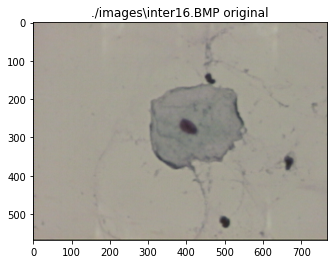

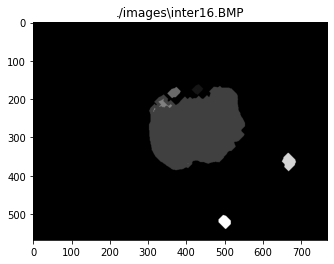

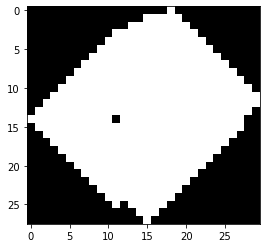

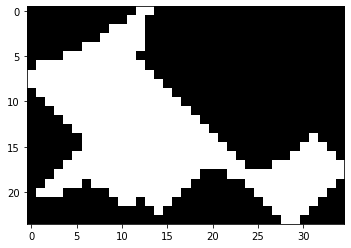

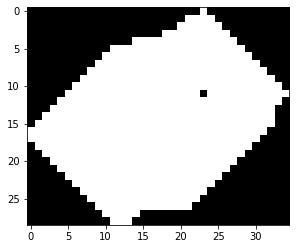

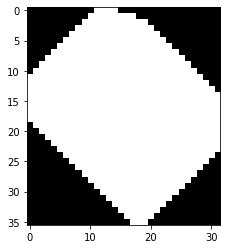

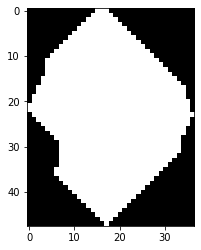

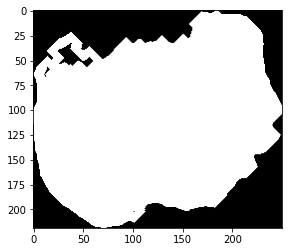

In [508]:
processAndPlot(samples[65])

In [ ]:
pd.DataFrame(np.load('data2.npy').to_csv('data2.csv')
pd.DataFrame(np.load('data3.npy').to_csv('data3.csv')